# Movie Rating Prediction with Python
### Goal: Analyze historical movie data and develop a model that predicts the rating of a moive based on features like genre, director, and actors. 

In [1]:
# imports
import pandas as pd   
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns 

### Data Exploration

In [84]:
# load data
df = pd.read_csv("./IMDb.csv", na_values="?",encoding='latin-1')

In [85]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15509 entries, 0 to 15508
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Name      15509 non-null  object 
 1   Year      14981 non-null  object 
 2   Duration  7240 non-null   object 
 3   Genre     13632 non-null  object 
 4   Rating    7919 non-null   float64
 5   Votes     7920 non-null   object 
 6   Director  14984 non-null  object 
 7   Actor 1   13892 non-null  object 
 8   Actor 2   13125 non-null  object 
 9   Actor 3   12365 non-null  object 
dtypes: float64(1), object(9)
memory usage: 1.2+ MB


In [86]:
df.describe()

,Rating
count,7919.000000
mean,5.841621
std,1.381777
min,1.100000
25%,4.900000
50%,6.000000
75%,6.800000
max,10.000000


In [87]:
df.head()

,Name,Year,Duration,Genre,Rating,Votes,Director,Actor 1,Actor 2,Actor 3
0,,NaN,NaN,Drama,NaN,NaN,J.S. Randhawa,Manmauji,Birbal,Rajendra Bhatia
1,#Gadhvi (He thought he was Gandhi),(2019),109 min,Drama,7.0,8,Gaurav Bakshi,Rasika Dugal,Vivek Ghamande,Arvind Jangid
2,#Homecoming,(2021),90 min,"Drama, Musical",NaN,NaN,Soumyajit Majumdar,Sayani Gupta,Plabita Borthakur,Roy Angana
3,#Yaaram,(2019),110 min,"Comedy, Romance",4.4,35,Ovais Khan,Prateik,Ishita Raj,Siddhant Kapoor
4,...And Once Again,(2010),105 min,Drama,NaN,NaN,Amol Palekar,Rajat Kapoor,Rituparna Sengupta,Antara Mali


In [88]:
df.isna().sum()

Name           0
Year         528
Duration    8269
Genre       1877
Rating      7590
Votes       7589
Director     525
Actor 1     1617
Actor 2     2384
Actor 3     3144
dtype: int64

Here we can notice some dirty data which can lead to inaccurate predictions. 
1. Name column has '#' special character
2. Year column has missing values and '()' around the year 
3. Duration column has missing values, some are described in hour and others in min, inconsistent
4. Genre column has multiple genres for some movies, missing values, so might consider feature engineering to split movies based on genre
5. Rating column has missing values
6. Votes column has missing values
5. Director column as well as actors columns have missing values. 

### Data Preprocessing

In [89]:
# 1. Name Column
# Remove duplicate rows based on movie name
df.drop_duplicates(subset='Name', keep='first', inplace=True)

# Remove special characters
df['Name'] = df['Name'].str.lstrip('!@#$%^&*()')

In [90]:
# Drop any rows with missing data
df.dropna(inplace=True)

In [91]:
df.isna().sum()

Name        0
Year        0
Duration    0
Genre       0
Rating      0
Votes       0
Director    0
Actor 1     0
Actor 2     0
Actor 3     0
dtype: int64

In [92]:
# Now that all 'NaN' values are handled, we can clean dirty data for the remainder of features
# Year - remove '()'

df['Year'] = df['Year'].str.extract('(\d+)').astype(int)

In [93]:
df['Duration']

1        109 min
3        110 min
5        147 min
6        142 min
8         82 min
          ...   
15493    115 min
15494    153 min
15503    125 min
15505    129 min
15508    130 min
Name: Duration, Length: 5148, dtype: object

In [94]:
# Duration - convert all values to min then get rid of alphanumeric values. Convert to type int. 

def convert_to_minutes(duration_str):
    if pd.isnull(duration_str) or duration_str == '':
        return None  # Return None for missing or empty strings
    # Initialize total minutes to zero
    total_minutes = 0
    # Check for the presence of hours
    if 'h' in duration_str or 'hr' in duration_str:
        # Find and convert the hours to minutes
        hours = int(duration_str.split('h')[0])
        total_minutes += hours * 60
        # Remove the hours part from the string
        duration_str = duration_str.split('h')[1]
    # Check and clean up the minutes part
    if 'm' in duration_str or 'min' in duration_str:
        # Extract minutes and convert to int
        minutes = int(''.join(filter(str.isdigit, duration_str)))
        total_minutes += minutes
    return total_minutes

# Re-apply the conversion function to the duration column
df['Duration'] = df['Duration'].apply(convert_to_minutes)

# Check the result
df['Duration']


1        109
3        110
5        147
6        142
8         82
        ... 
15493    115
15494    153
15503    125
15505    129
15508    130
Name: Duration, Length: 5148, dtype: int64

In [95]:
df['Genre']

1                            Drama
3                  Comedy, Romance
5           Comedy, Drama, Musical
6              Drama, Romance, War
8        Horror, Mystery, Thriller
                   ...            
15493                        Drama
15494    Biography, Drama, History
15503         Action, Crime, Drama
15505                Action, Drama
15508                Action, Drama
Name: Genre, Length: 5148, dtype: object

In [96]:
# Genre - split ',' for all unique values

df['Genre'] = df['Genre'].str.split(',')
df = df.explode('Genre')

In [98]:
# Removing duplicates
df = df.drop_duplicates(subset='Name')

In [99]:
df['Genre']

1            Drama
3           Comedy
5           Comedy
6            Drama
8           Horror
           ...    
15493        Drama
15494    Biography
15503       Action
15505       Action
15508       Action
Name: Genre, Length: 5148, dtype: object

In [100]:
# Votes - remove commas

df['Votes'] = df['Votes'].str.replace(',', '').astype(int)

In [101]:
# Finally, reset the index
df.reset_index(drop=True, inplace=True)

In [102]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5148 entries, 0 to 5147
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Name      5148 non-null   object 
 1   Year      5148 non-null   int32  
 2   Duration  5148 non-null   int64  
 3   Genre     5148 non-null   object 
 4   Rating    5148 non-null   float64
 5   Votes     5148 non-null   int32  
 6   Director  5148 non-null   object 
 7   Actor 1   5148 non-null   object 
 8   Actor 2   5148 non-null   object 
 9   Actor 3   5148 non-null   object 
dtypes: float64(1), int32(2), int64(1), object(6)
memory usage: 362.1+ KB


In [103]:
df['Name'].describe()

count                                  5148
unique                                 5148
top       Gadhvi (He thought he was Gandhi)
freq                                      1
Name: Name, dtype: object

In [104]:
df['Duration'].unique()

array([109, 110, 147, 142,  82, 116,  96, 120, 161, 166, 102,  87, 132,
       146, 168, 158, 126,  94, 138, 124, 144, 157, 136, 107, 113,  80,
       122, 149, 148, 130, 121, 188, 115, 103, 114, 170, 100,  99, 140,
       128,  93, 125, 145,  75, 111, 134, 104,  92, 137, 127, 119, 135,
        90, 105, 150, 151,  95, 112, 143, 177, 117, 123, 154, 175,  78,
       133, 180, 153,  46, 164, 162, 171, 160, 139, 152, 163, 129, 156,
       240, 172,  88, 155, 167, 106, 193, 141, 108, 195, 174,  81, 165,
       178,  58, 184,  97, 176, 169, 131,  77,  91,  86,  84, 173, 118,
       181, 300,  70, 101,  79,  65,  48, 159,  83,  72,  68,  89, 201,
        64, 186,  74,  85,  98,  49,  60, 207, 185, 183, 187, 216,  51,
        71,  45,  73,  57, 191, 321, 199, 179,  47, 206,  63, 211, 247,
        56, 213, 210, 190, 223, 189, 224, 202,  69, 255, 197, 182,  66,
       214, 208,  59,  21, 192,  50,  54, 200, 238,  62,  67,  52,  76,
       204, 235, 217, 250], dtype=int64)

In [105]:
# Save the cleaned data to a new CSV file
df.to_csv('clean_movie_data.csv', index=False)

In [2]:
df_clean = pd.read_csv('clean_movie_data.csv')

In [3]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5148 entries, 0 to 5147
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Name      5148 non-null   object 
 1   Year      5148 non-null   int64  
 2   Duration  5148 non-null   int64  
 3   Genre     5148 non-null   object 
 4   Rating    5148 non-null   float64
 5   Votes     5148 non-null   int64  
 6   Director  5148 non-null   object 
 7   Actor 1   5148 non-null   object 
 8   Actor 2   5148 non-null   object 
 9   Actor 3   5148 non-null   object 
dtypes: float64(1), int64(3), object(6)
memory usage: 402.3+ KB


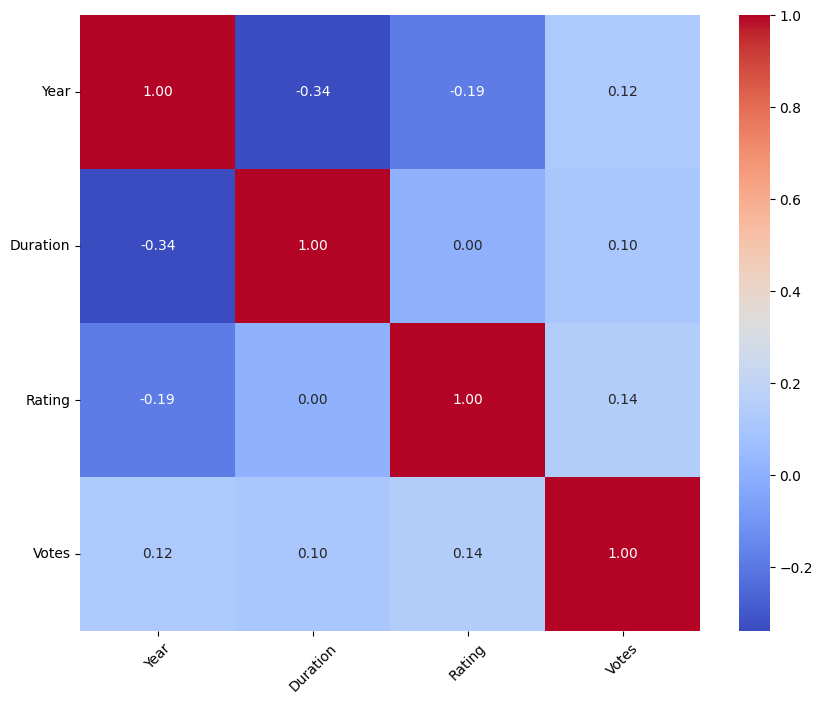

In [4]:
# Now, we can create a correlation matrix from the numerical columns of the clean dataset
numerical_df = df_clean.select_dtypes(include=['int64', 'float64', 'int32'])

# Calculate the correlation matrix
corr_matrix = numerical_df.corr()

plt.figure(figsize=(10, 8))

# Draw the heatmap
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm')

# Adjust layout for better readability
plt.xticks(rotation=45, ha='center')
plt.yticks(rotation=0)

# Show plot
plt.show()


There's no direct linear correlation with any of the numerical data, we can only assume that the number of votes were much higher for earlier years, the duration was also higher.

#### Prepare data for model fitting

1. Encode object type data: Genre via one-hot encoding. Director, Actor 1-3 using frequency encoding to reduce dimensionality. 
2. Standardize the data between 0-1 standard deviation range for faster performance. 

In [5]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler

# One-hot encode the 'Genre' column
one_hot_encoder = OneHotEncoder(sparse=False)
genre_encoded = one_hot_encoder.fit_transform(df_clean[['Genre']])

# Convert the encoded genres back to a DataFrame with appropriate column names
genre_encoded_df = pd.DataFrame(genre_encoded, columns=one_hot_encoder.get_feature_names_out(['Genre']))

# Frequency encode the 'Director', 'Actor 1', 'Actor 2', and 'Actor 3' columns
for column in ['Director', 'Actor 1', 'Actor 2', 'Actor 3']:
    frequency = df_clean[column].value_counts(normalize=True)
    df_clean[column + '_Freq'] = df_clean[column].map(frequency)

# Drop original object columns after encoding
data_encoded = df_clean.drop(['Name', 'Genre', 'Director', 'Actor 1', 'Actor 2', 'Actor 3'], axis=1)

# Merge the one-hot encoded genre back into the dataframe
data_encoded = pd.concat([data_encoded, genre_encoded_df], axis=1)

# Standardize numerical features
scaler = StandardScaler()
numerical_columns = ['Year', 'Duration', 'Rating', 'Votes', 'Director_Freq', 'Actor 1_Freq', 'Actor 2_Freq', 'Actor 3_Freq']
data_encoded[numerical_columns] = scaler.fit_transform(data_encoded[numerical_columns])

# Display the first few rows of the processed dataframe for model fitting
data_encoded.head()


,Year,Duration,Rating,Votes,Director_Freq,Actor 1_Freq,Actor 2_Freq,Actor 3_Freq,Genre_Action,Genre_Adventure,...,Genre_History,Genre_Horror,Genre_Music,Genre_Musical,Genre_Mystery,Genre_Romance,Genre_Sci-Fi,Genre_Sport,Genre_Thriller,Genre_War
0,1.125389,-0.931601,0.784895,-0.195303,-0.739725,-0.702425,-0.784913,-0.666642,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.125389,-0.892485,-1.088942,-0.193398,-0.739725,-0.582800,-0.784913,-0.539845,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-0.002250,0.554803,-0.872730,-0.137522,1.002185,-0.223928,0.611629,0.601322,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.407800,0.359223,1.073178,-0.119250,-0.013929,-0.064429,-0.570061,0.220933,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.766595,-1.987731,-0.224094,-0.172868,-0.739725,-0.742299,-0.247782,-0.666642,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Let's take a look into data distribution for all features and reduce dimensionality if needed

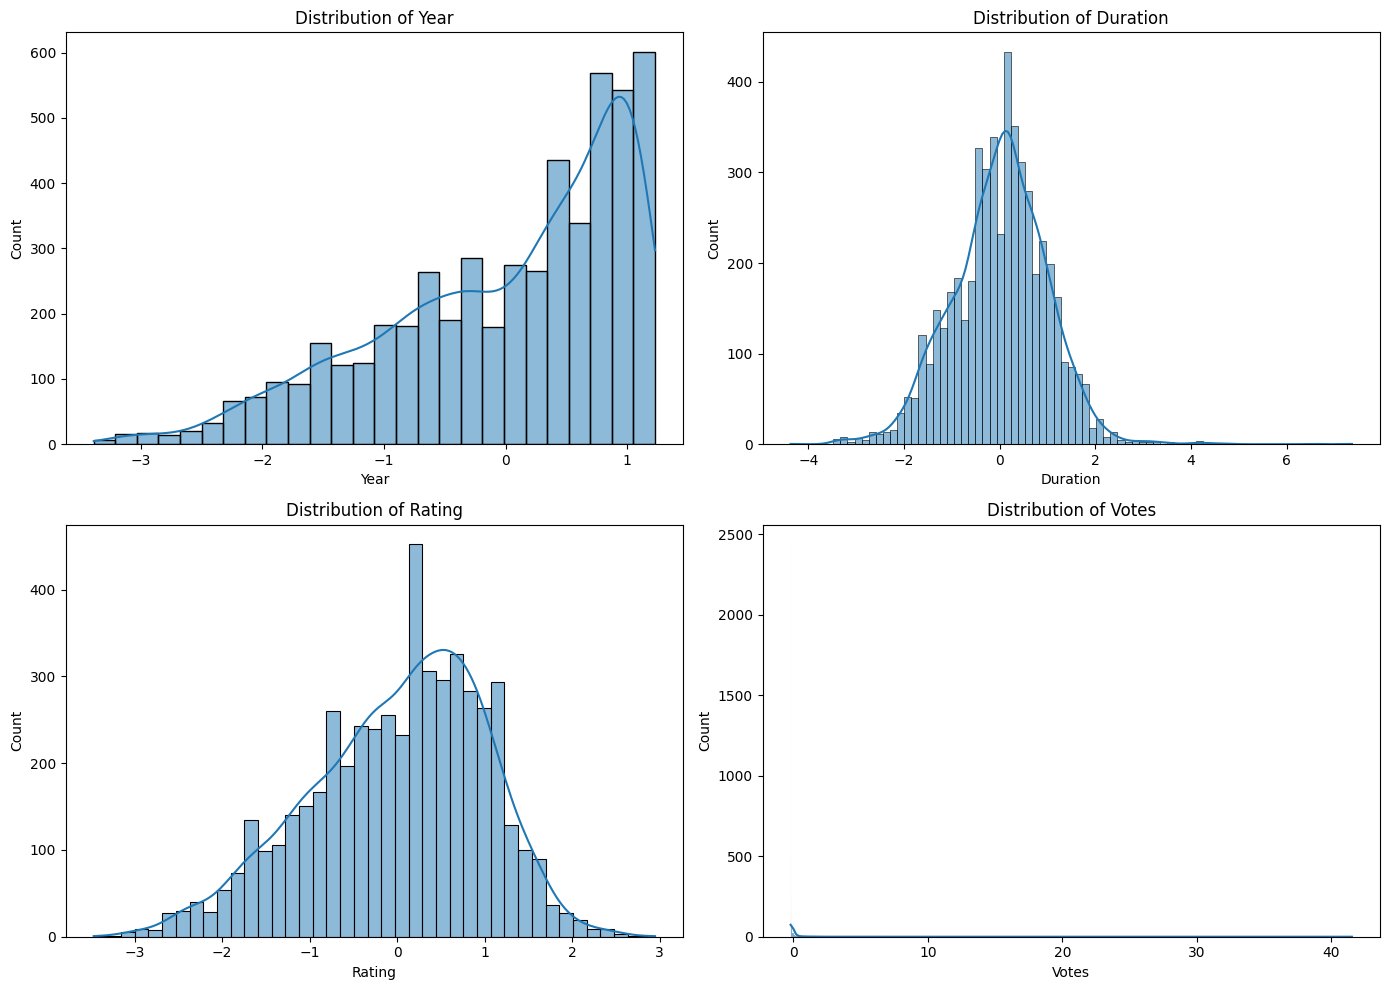

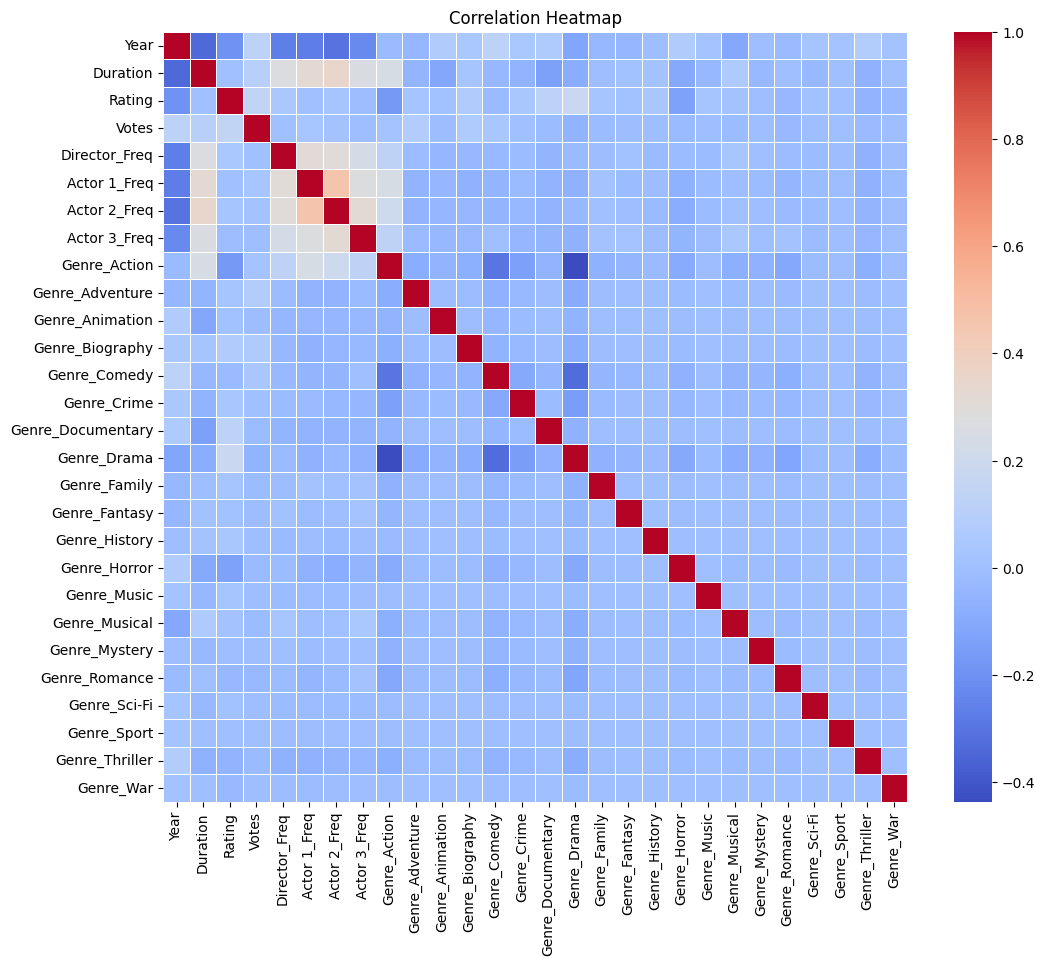

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA

fig, axs = plt.subplots(2, 2, figsize=(14, 10))

numerical_features = ['Year', 'Duration', 'Rating', 'Votes']
for i, feature in enumerate(numerical_features):
    sns.histplot(data_encoded[feature], ax=axs[i//2, i%2], kde=True)
    axs[i//2, i%2].set_title(f'Distribution of {feature}')

fig.tight_layout()

# Heatmap of Correlations
plt.figure(figsize=(12, 10))
sns.heatmap(data_encoded.corr(), cmap="coolwarm", annot=False, lw=0.5)
plt.title('Correlation Heatmap')
plt.show()


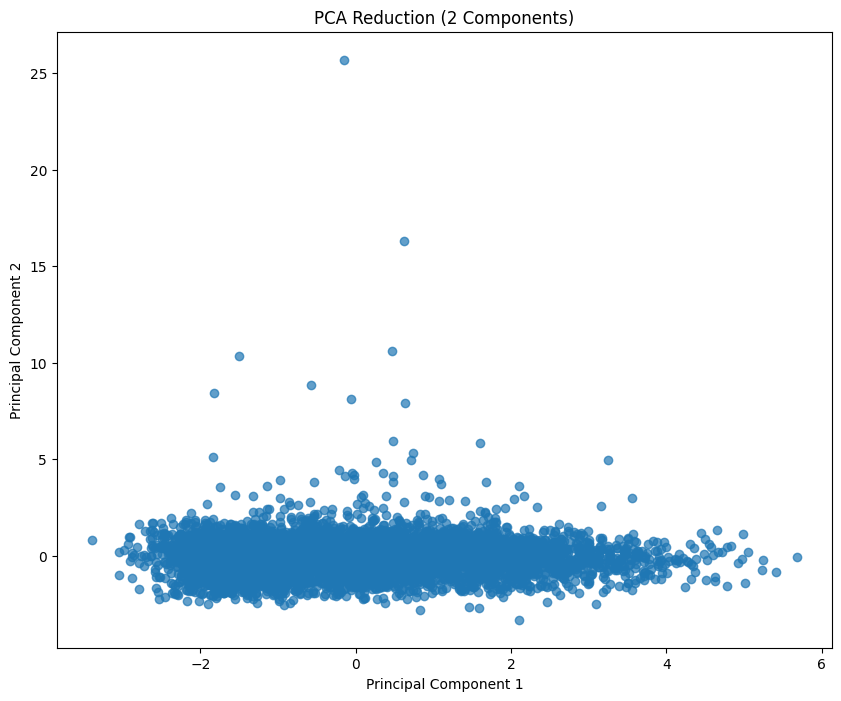

In [7]:
# PCA Reduction to visualize data in a 2D space and Plot
pca = PCA(n_components=2)
pca_result = pca.fit_transform(data_encoded)

plt.figure(figsize=(10, 8))
plt.scatter(pca_result[:, 0], pca_result[:, 1], alpha=0.7)
plt.title('PCA Reduction (2 Components)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

Here we can see that most of these features have an even distribution, year seems to be left skewed however and votes seems to be right skewed. Using PCA, it is apparent that all the features are complex and might be directly related as there were no separate groups formed from the scatter plot visualized to view the relationships of data in a 2D plane. 

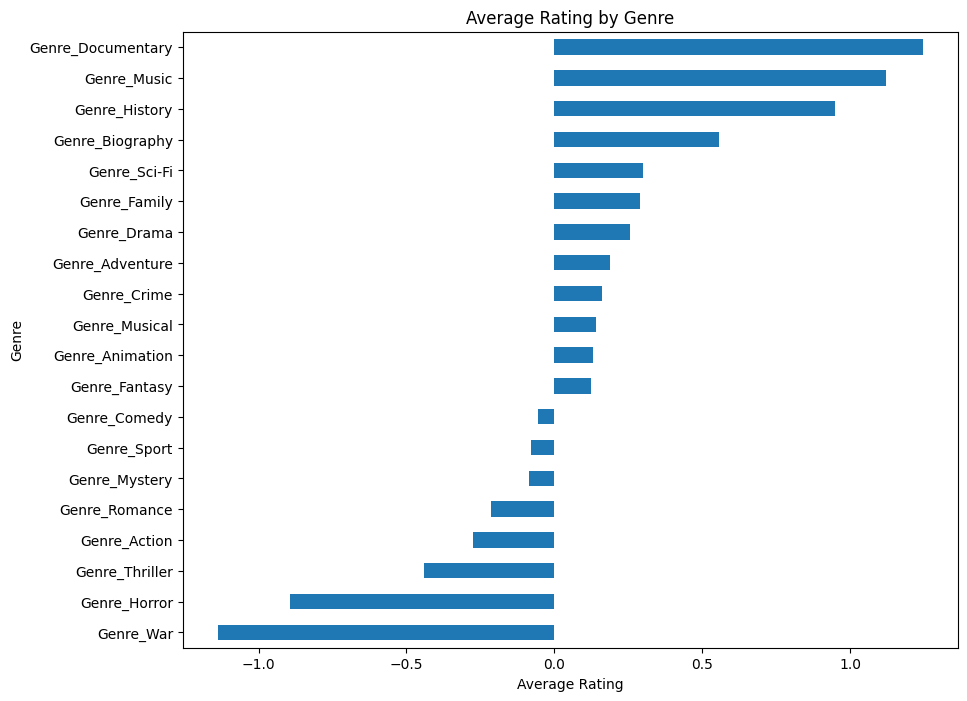

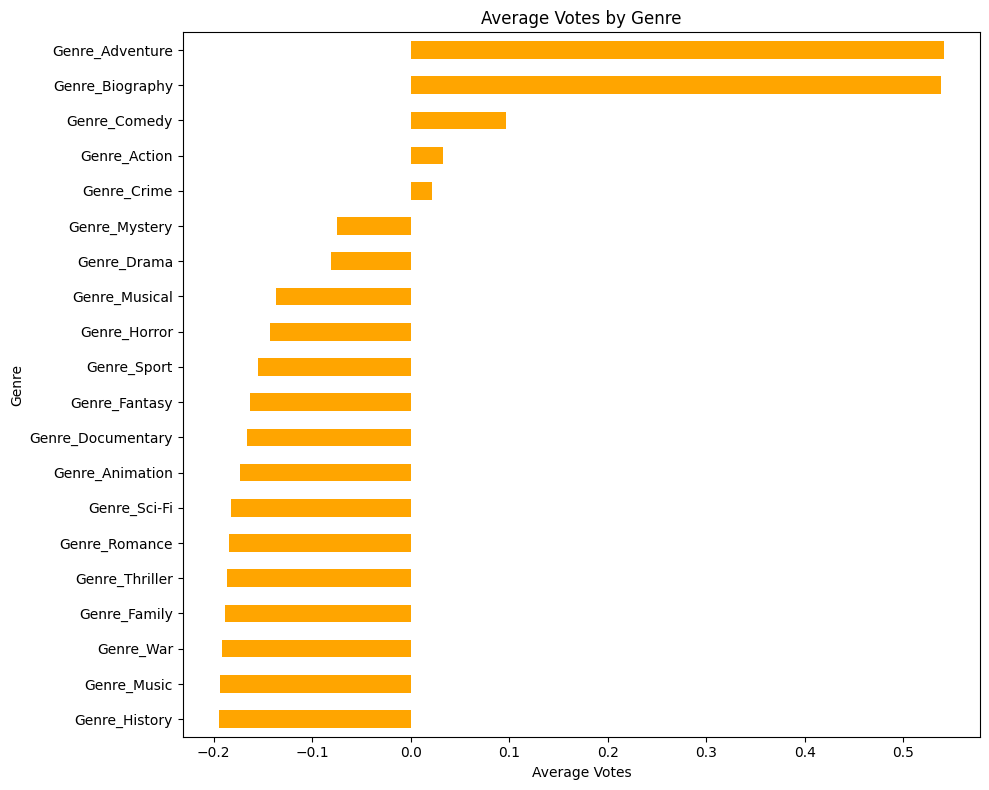

In [10]:
# Visualization of genre and how it influces votes/rating
genre_columns = [col for col in data_encoded.columns if col.startswith('Genre_')]

# Calculate avg rating and votes per genre
genre_avg_rating = {}
genre_avg_votes = {}
for genre in genre_columns:
    genre_avg_rating[genre] = data_encoded.loc[data_encoded[genre] == 1, 'Rating'].mean()
    genre_avg_votes[genre] = data_encoded.loc[data_encoded[genre] == 1, 'Votes'].mean()

genre_rating_series = pd.Series(genre_avg_rating)
genre_votes_series = pd.Series(genre_avg_votes)

# Plotting avg rating per genre
plt.figure(figsize=(10, 8))
genre_rating_series.sort_values().plot(kind='barh')
plt.title('Average Rating by Genre')
plt.xlabel('Average Rating')
plt.ylabel('Genre')

# Plotting avg votes per genre
plt.figure(figsize=(10, 8))
genre_votes_series.sort_values().plot(kind='barh', color='orange')
plt.title('Average Votes by Genre')
plt.xlabel('Average Votes')
plt.ylabel('Genre')

plt.tight_layout()
plt.show()


From the visualization, we can see that certain movies depending on their genres receive more votes resulting in higher ratings. Genres like Adventure and Action seem to have this correlation. 

### Model Fitting

#### Linear Regression

In [15]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Defining features and target variable
X = data_encoded.drop('Rating', axis=1)
y = data_encoded['Rating']

# Splitting the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fitting a Linear Regression Model
linear_reg = LinearRegression()
linear_reg.fit(X_train, y_train)

# Predictions
y_pred = linear_reg.predict(X_test)

# Evaluating the model
mse_ns = mean_squared_error(y_test, y_pred)
r2_ns = r2_score(y_test, y_pred)

mse_ns, r2_ns


(0.15160787308792825, 0.858944204726515)

As noticed above, using linear regression, the MSE is relatively low at about 15% meaning the model has a high accuracy in terms of predictions. The R-squared value achieved using this model is 85% which indicates theat the variance in movie ratings can be explained by the given features in this dataset. 

In [23]:
def test(model):
    # Taking a random sample from the original data for test
    random_sample = data_encoded.sample(n=1, random_state=42)

    # Extracting the features and the actual rating for comparison
    sample_features = random_sample.drop('Rating', axis=1)
    actual_rating = random_sample['Rating'].values[0]

    # Predicting the rating using the trained linear regression model
    predicted_rating = model.predict(sample_features)[0]

    print(actual_rating, predicted_rating)


In [24]:
test(linear_reg)

1.3614605801045727 1.2120233306856716


In the test sample above, after testing it on the trained model, we can see that the actual rating v. the predicted rating are real close to each other. The predicted deviates from the actual by a factor of 0.15 which is the expected MSE we achieved while training the model. 

#### Model Fitting for Huber Regressor - more robust for any potential outliers

In [20]:
from sklearn.linear_model import HuberRegressor

# Model fitting - Huber Regressor
huber_reg = HuberRegressor()
huber_reg.fit(X_train, y_train)

# Predictions using the Huber Regressor
y_pred_huber = huber_reg.predict(X_test)

# Evaluating the Huber Regressor model
mse_huber = mean_squared_error(y_test, y_pred_huber)
r2_huber = r2_score(y_test, y_pred_huber)

mse_huber, r2_huber


C:\Users\Jaswa\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_huber.py:335: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


(0.1650008929609262, 0.846483354040986)

In [25]:
test(huber_reg)

1.3614605801045727 1.1493636949889847
